# Center Loss in Keras - Fine Tuning

### Item recognition 'the sequel 2' - using Center Loss with Transfer Learning

Previously, I trained a model to recognise photos of items/products using Center Loss technique. The model includes pre-trained inceptionV3 model excluding the final layer with weights being untrainable, fully connected layers following that, and two output layers of the softmax classification layer and the customised center loss layer at last.

With center loss lambda ~= 0.001, both loss values and a plot seemd good until the training reached around epoch 10. After that, center loss rather started to increase while softmax loss kept decrease.

In this notebook, I will try fine tuning technique on the pre-trained model.


Pretrained model: InceptionV3

The implementation of **Center Loss** came from: [handongfeng/MNIST-center-loss](https://github.com/handongfeng/MNIST-center-loss/blob/master/centerLoss_MNIST.py)

**Articles:**
- [A Discriminative Feature Learning Approach for Deep Face Recognition](https://ydwen.github.io/papers/WenECCV16.pdf)
- [Understanding Center Loss Based Network for Image Retrieval with Few Training Data](https://openaccess.thecvf.com/content_ECCVW_2018/papers/11132/Ghosh_Understanding_Center_Loss_Based_Network_for_Image_Retrieval_with_Few_ECCVW_2018_paper.pdf)

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
%matplotlib notebook
%load_ext tensorboard

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.preprocessing import image_dataset_from_directory # cant import in Tensorflow v2.2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.regularizers import l2
from tensorflow.keras import losses
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import default_rng

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


In [3]:
#import os

In [4]:
from centerLoss import prelu, zero_loss, my_model
from centerLoss import CenterLossLayer

In [5]:
from utils import tbProjector, PCAPlotter, create_testdata

In [6]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Counting Training Data 

In [8]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#print(x_train.shape)

In [9]:
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, BatchNormalization, Activation
#from tensorflow.keras.layers import Dropout, Flatten, Dense
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import Model
#from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [10]:
image_dir = "image_data"
train_dir = os.path.join(image_dir, "train")
print(train_dir)

train_classnum = len(os.listdir(train_dir))
print("items = {}".format(len(os.listdir(train_dir))))

image_data/train
items = 706


In [11]:
all_images = 0
class_list = sorted(os.listdir(train_dir))
for i in class_list:
    #print(i)
    all_images += len(os.listdir(os.path.join(train_dir, i)))
print("All image files = {}".format(all_images))
print("class_list[:10] = {}".format(class_list[:10]))

All image files = 12070
class_list[:10] = ['aubeer2_0', 'aubeer2_1', 'aubeer2_10', 'aubeer2_11', 'aubeer2_12', 'aubeer2_14', 'aubeer2_15', 'aubeer2_16', 'aubeer2_17', 'aubeer2_18']


In [12]:
#_BATCH_SIZE = 1024
#_BATCH_SIZE = 256
_BATCH_SIZE = 64

## Setup train data generator

In [13]:
'''
train_ds = image_dataset_from_directory(
    directory='image_data/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=_BATCH_SIZE,
    image_size=(224, 224))
'''

"\ntrain_ds = image_dataset_from_directory(\n    directory='image_data/train',\n    labels='inferred',\n    label_mode='categorical',\n    batch_size=_BATCH_SIZE,\n    image_size=(224, 224))\n"

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'image_data/train',
    target_size=(224, 224),
    batch_size=_BATCH_SIZE,
    class_mode='categorical'
    ) 

Found 12070 images belonging to 706 classes.


In [15]:
def plot_dataset(image_samples):

    #plt.figure(figsize=(5, 2))
    fig, axs = plt.subplots(len(image_samples)//5, 5)
                            
    count = 0
    for i in range(len(image_samples)//5):
        for j in range(5):
            #print("i = {}, j = {}".format(i, j))
            #plt.subplot(3, 3, 1 + i + j)
            axs[i, j].imshow(image_samples[count])
            plt.xticks([])
            plt.yticks([])
            count+=1
        #plt.title(examples[1][i])
    plt.show()

In [16]:
#X, Y = train_ds
(X, Y) = next(train_generator)
print(X.shape)
print(Y.shape)

plot_dataset(X[:10])
#print(Y[:10])

(64, 224, 224, 3)
(64, 706)


<IPython.core.display.Javascript object>

In [17]:
labelnames = list(train_generator.class_indices.keys())

for y_onehot in Y[:10]:
    idx = np.argmax(y_onehot, axis=0)
    print(labelnames[idx]) 

drink4
aubeer2_91
aubeer2_42
snack80
aubeer2_64
aubeer2_46
austeafood_000047
drink120
aubeer2_21
aubeer_89


## Load a pre-trained model and attach some fully-connected layers

In [18]:
emb_size = 128

img_input = keras.Input(shape=(224, 224, 3))
train_labels = keras.Input(shape=(train_classnum,))

final_output, side_output, base_model = my_model(img_input, train_labels, emb_size)
model = keras.Model(inputs=[img_input, train_labels], outputs=[final_output, side_output])
model.summary()

706
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 5, 5, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           inception_v3[1][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           global_average_pooling2d[0][0]   
__________________________________________________________________________________________

## compile

In [19]:
lambda_centerloss = 0.001
initial_learning_rate = 0.001

optim = optimizers.SGD(lr=initial_learning_rate, momentum=0.9)
model.compile(optimizer=optim,
                  loss=[losses.categorical_crossentropy, zero_loss],
                  #loss_weights=[1, lambda_centerloss])
                  loss_weights=[1, lambda_centerloss])

## Define data generation wrapper

In [20]:
def datagen_wrapper(gen, batch_size=64):
    dummy = np.zeros((batch_size, 1))
    #dummy2 = np.zeros((x_test.shape[0], 1))
    while True:
        (X, Y) = next(gen)    
        yield([X, Y], [Y, dummy])


## Prepare Tensorboard log

In [21]:
from datetime import date, time, datetime
import time

#datetimestr = datetime.now().__str__()
#timestamp = datetimestr.split()[0] + "_" + datetimestr.split()[1].split('.')[0]

epoch_time = int(time.time())

In [22]:
log_dir_rel = "logs/logs-{}".format(epoch_time)
#log_dir = os.path.abspath(log_dir_rel)
log_dir = os.path.abspath("logs/train_log")

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
_TB_METADATA = 'metadata.tsv'

print(log_dir)

/home/chieko/Projects/ImageRecognition2/ItemRecogCenterLoss/logs/train_log


In [23]:
# Validation Data for Tensorboard
x_tb, x_tb_label_list = create_testdata(datadir='train', tblog_dir=log_dir, metadatafile=_TB_METADATA)
y_tb = np.zeros((x_tb.shape[0], emb_size))

x_tb_label = [ train_generator.class_indices[label] for label in x_tb_label_list ]
print(x_tb_label)

[109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 186, 186, 186, 186, 186, 186, 457, 457, 457, 457, 457, 457, 457, 457, 457, 457, 457, 457, 457, 457, 457, 357, 357, 357, 357, 357, 357, 357, 357, 357, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 323, 323, 323, 323, 323, 323, 323, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270]


## Training with pre-trained model being untrainable

<IPython.core.display.Javascript object>


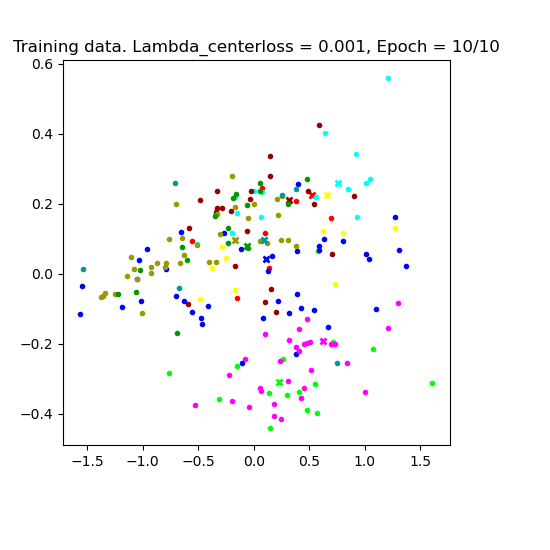

y_seq = [323 357 457 395 109 173 207 271 270 186], len = (10,)
Epoch 1/10
188/188 [==============================] - 54s 286ms/step - loss: 6.8617 - main_out_loss: 6.5746 - centerlosslayer_loss: 245.2291
Epoch 2/10
188/188 [==============================] - 53s 281ms/step - loss: 6.6664 - main_out_loss: 6.5545 - centerlosslayer_loss: 70.2714
Epoch 3/10
188/188 [==============================] - 53s 282ms/step - loss: 6.6342 - main_out_loss: 6.5452 - centerlosslayer_loss: 47.4195
Epoch 4/10
188/188 [==============================] - 53s 282ms/step - loss: 6.6138 - main_out_loss: 6.5348 - centerlosslayer_loss: 37.4650
Epoch 5/10
188/188 [==============================] - 53s 283ms/step - loss: 6.5997 - main_out_loss: 6.5261 - centerlosslayer_loss: 32.1254
Epoch 6/10
188/188 [==============================] - 53s 282ms/step - loss: 6.5854 - main_out_loss: 6.5149 - centerlosslayer_loss: 29.0532
Epoch 7/10
188/188 [==============================] - 53s 282ms/step - loss: 6.5733 - main_out_l

In [24]:
epochs=10
steps_per_epoch = int(all_images/_BATCH_SIZE)
#steps_per_epoch = 10

reduced_model = keras.Model(inputs=model.input[0], outputs=model.get_layer('side_out').output)

model.fit(datagen_wrapper(train_generator, _BATCH_SIZE),
            steps_per_epoch=steps_per_epoch,
            #batch_size=_BATCH_SIZE,
            epochs=epochs,
            verbose=1,
            callbacks=[
                    tbProjector(reduced_model, x_tb, y_tb, log_dir, _TB_METADATA),
                    PCAPlotter(plt, model, reduced_model, x_tb, x_tb_label, epochs, lambda_centerloss)])

**NOTE**

- `lambda = 0.01`: Most of the points which represent samples became tightly close to each other, looking like it's just one point in the plot at the end of the first epoch.

- `lambda = 0.0007 - 0.001 - 0.003`: Better. But after around 10th epoch, center loss started to increase AND keep increasing although it was reasonably decreasing until that point. On the other hand, main loss (categorical cross entropy) kept decreasing throughout the training.

In [25]:
plt.savefig('results/train_toplayer_plot.jpg')

## Fine Tuning

In [26]:
base_model.trainable = True

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 5, 5, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           inception_v3[1][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           global_average_pooling2d[0][0]   
______________________________________________________________________________________________

In [28]:
lambda_centerloss = 0.005


optim = optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=optim,
                  loss=[losses.categorical_crossentropy, zero_loss],
                  loss_weights=[1, lambda_centerloss])

<IPython.core.display.Javascript object>


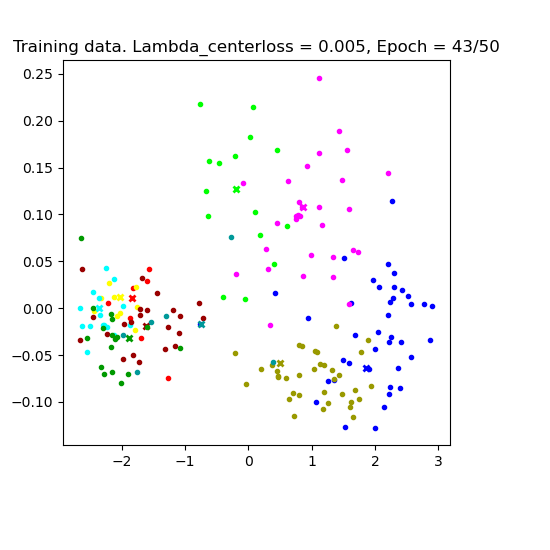

y_seq = [323 357 457 395 109 173 207 271 270 186], len = (10,)
Epoch 1/50
188/188 [==============================] - 192s 1s/step - loss: 6.5933 - main_out_loss: 6.4655 - centerlosslayer_loss: 17.2938
Epoch 2/50
188/188 [==============================] - 190s 1s/step - loss: 6.5671 - main_out_loss: 6.4723 - centerlosslayer_loss: 10.7134
Epoch 3/50
188/188 [==============================] - 190s 1s/step - loss: 6.5567 - main_out_loss: 6.4730 - centerlosslayer_loss: 8.4841
Epoch 4/50
188/188 [==============================] - 190s 1s/step - loss: 6.5512 - main_out_loss: 6.4735 - centerlosslayer_loss: 7.2769
Epoch 5/50
188/188 [==============================] - 190s 1s/step - loss: 6.5467 - main_out_loss: 6.4728 - centerlosslayer_loss: 6.5088
Epoch 6/50
188/188 [==============================] - 190s 1s/step - loss: 6.5427 - main_out_loss: 6.4711 - centerlosslayer_loss: 6.0739
Epoch 7/50
188/188 [==============================] - 190s 1s/step - loss: 6.5397 - main_out_loss: 6.4696 - cente

ResourceExhaustedError:  OOM when allocating tensor with shape[64,2048,5,5] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/inception_v3/mixed10/concat (defined at <ipython-input-29-cb1994366ad6>:14) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_44662]

Function call stack:
train_function


In [29]:
epochs=50
steps_per_epoch = int(all_images/_BATCH_SIZE)
#steps_per_epoch = 10

reduced_model = keras.Model(inputs=model.input[0], outputs=model.get_layer('side_out').output)

model.fit(datagen_wrapper(train_generator, _BATCH_SIZE),
            steps_per_epoch=steps_per_epoch,
            #batch_size=_BATCH_SIZE,
            epochs=epochs,
            verbose=1,
            callbacks=[
                    tbProjector(reduced_model, x_tb, y_tb, log_dir, _TB_METADATA),
                    PCAPlotter(plt, model, reduced_model, x_tb, x_tb_label, epochs, lambda_centerloss)])

In [ ]:
#model_filename = "centerloss_" + str(epoch_time) + ".h5"

#model.save(model_filename)
#print("Trained model was saved into {}.".format(model_filename))

In [ ]:
reduced_filename = "reduced_" + str(epoch_time) + ".h5"
reduced_model.save(reduced_filename)
print("Trained model was saved into {}.".format(reduced_filename))

In [ ]:
weights_filename = "weights_" + str(epoch_time) + ".h5"
model.save_weights(weights_filename)
print("Trained model weights were saved into {}.".format(weights_filename))